In [4]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs

In [5]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [7]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'




Figures will be saved in: /home/561/erd561/figures/SAMexp/t03_time_series



In [8]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: 'tcp://127.0.0.1:44159' processes=4 threads=8, memory=33.67 GB>
CPU times: user 897 ms, sys: 232 ms, total: 1.13 s
Wall time: 18.7 s


In [9]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(501, 576)
hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(576, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var1 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[ -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
130
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ice_month.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ice_month.nc
/g/

In [10]:
%%time

sst = []
for p in path1:
    if p == path1[0]:
        sst = \
            xr.open_dataset(p, decode_times=False).\
            SST.\
            mean(dim='time')
        print(str(p) + ' OK')
            
    else:
        sst = \
            xr.concat([
                sst,
                xr.open_dataset(p, decode_times=False).\
                SST.\
                mean(dim='time')
            ], 'year'
            )
        print(str(p) + ' OK')
print(sst.shape)

sst = sst.assign_coords(year=years)

sst_all = sst.\
    mean(dim=('yt', 'xt'))

lon_GAB = [112, 145]
lat_GAB = [-41, -31]
sst_GAB = \
    sst.\
    sel(yt=slice(lat_GAB[0],lat_GAB[1]), 
        xt=slice(lon_GAB[0]-360,lon_GAB[1]-360)).\
    mean(dim=('yt', 'xt'))

lon_TS = [148, 157]
lat_TS = [-45, -32]
sst_TS = \
    sst.\
    sel(yt=slice(lat_TS[0],lat_TS[1]), 
        xt=slice(lon_TS[0]-360,lon_TS[1]-360)).\
    mean(dim=('yt', 'xt'))



FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ice_month.nc'

In [44]:
%%time

for p in path2:
    print(p)
    if p == path2[0]:
        tau_x = \
            xr.open_dataset(p, decode_times=False).\
            tau_x.\
            sel(yu_ocean=slice(lat_GAB[0],lat_GAB[1]), 
            xu_ocean=slice(lon_GAB[0]-360,lon_GAB[1]-360)).\
            mean(dim=('yu_ocean', 'xu_ocean', 'time'))
        
        sea_level = \
            xr.open_dataset(p, decode_times=False).\
            sea_level.\
            sel(yt_ocean=slice(lat_TS[0],lat_TS[1]), 
            xt_ocean=slice(lon_TS[0]-360,lon_TS[1]-360)).\
            mean(dim=('yt_ocean', 'xt_ocean', 'time'))*100
        
        print(str(p) + ' OK')
            
    elif 'v45' in p:
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p, decode_times=False).\
                tau_x.\
                sel(yu_ocean=slice(lat_GAB[0],lat_GAB[1]), 
                xu_ocean=slice(lon_GAB[0]-360,lon_GAB[1]-360)).\
                mean(dim=('yu_ocean', 'xu_ocean', 'time'))
            ], 'year'
            )
        
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p, decode_times=False).\
                sea_level.\
                sel(yt_ocean=slice(lat_TS[0],lat_TS[1]), 
                xt_ocean=slice(lon_TS[0]-360,lon_TS[1]-360)).\
                mean(dim=('yt_ocean', 'xt_ocean', 'time'))*100
            ], 'year'
            )
        print(str(p) + ' OK')
    
    else:
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p, decode_times=False).\
                tau_x.\
                sel(yu_ocean=slice(lat_GAB[0],lat_GAB[1]), 
                xu_ocean=slice(lon_GAB[0]-360,lon_GAB[1]-360)).\
                mean(dim=('yu_ocean', 'xu_ocean', 'time'))
            ], 'year'
            )
        
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p, decode_times=False).\
                sea_level.\
                sel(yt_ocean=slice(lat_TS[0],lat_TS[1]), 
                xt_ocean=slice(lon_TS[0]-360,lon_TS[1]-360)).\
                mean(dim=('yt_ocean', 'xt_ocean', 'time'))*100
            ], 'year'
            )
        print(str(p) + ' OK')

tau_x = tau_x.assign_coords(year=years)
sea_level = sea_level.assign_coords(year=years)
print(tau_x)
print(sea_level)

/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc
/g/data/v45/pas561/

/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output543/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output544/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output544/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output545/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output545/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output546/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output546/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output547/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output547/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output548/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output548/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output549/ocean_month.nc
/g/data/e14/erd561/mom

/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output595/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output598/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output598/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output599/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output599/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output600/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output600/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output601/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output601/ocean_mon

In [53]:
tau_x = tau_x.assign_coords(year=years)
sea_level = sea_level.assign_coords(year=years)

CPU times: user 3.65 s, sys: 1.69 s, total: 5.34 s
Wall time: 3.21 s


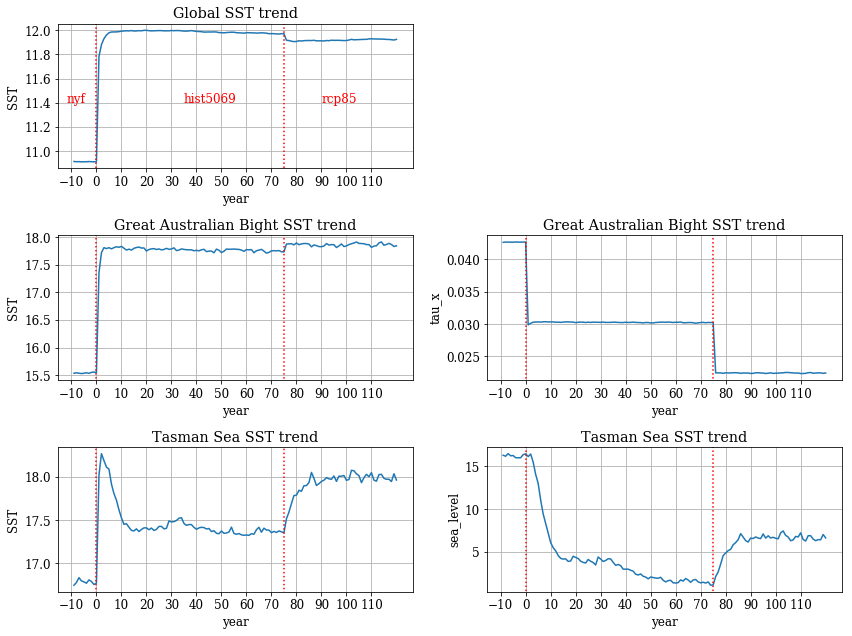

In [56]:
%%time

matplotlib.rcParams.update({'font.size': 12}) 
row = 3
col = 2
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plt.close('all')
fig = plt.figure() 
fig.set_size_inches(12,10)


##
ax = plt.subplot(row,col,1)
sst_all.plot()
plt.title('Global SST trend')
# plt.ylim([-1.3, 1.3])
# plt.yticks(np.arange(-1,1.5,0.5))
plt.xticks(np.arange(-10,120,10))
ax.grid()
plt.plot(
    [years[9], years[9]], [-1, 140], 
    [years[84], years[84]], [-1, 140], 
    color='r', linestyle=':')
plt.text(-12,11.4,'nyf',color='r')
plt.text(35,11.4,'hist5069',color='r')
plt.text(90,11.4,'rcp85',color='r')


##
ax = plt.subplot(row,col,3)
sst_GAB.plot()
plt.title('Great Australian Bight SST trend')
# plt.ylim([-1.3, 1.3])
# plt.yticks(np.arange(-1,1.5,0.5))
plt.xticks(np.arange(-10,120,10))
ax.grid()
plt.plot(
    [years[9], years[9]], [-1, 140], 
    [years[84], years[84]], [-1, 140], 
    color='r', linestyle=':')

##
ax = plt.subplot(row,col,5)
sst_TS.plot()
plt.title('Tasman Sea SST trend')
# plt.ylim([-1.3, 1.3])
# plt.yticks(np.arange(-1,1.5,0.5))
plt.xticks(np.arange(-10,120,10))
ax.grid()
plt.plot(
    [years[9], years[9]], [-1, 140], 
    [years[84], years[84]], [-1, 140], 
    color='r', linestyle=':')

##
ax = plt.subplot(row,col,4)
tau_x.plot()
plt.title('Great Australian Bight SST trend')
# plt.ylim([-1.3, 1.3])
# plt.yticks(np.arange(-1,1.5,0.5))
plt.xticks(np.arange(-10,120,10))
ax.grid()
plt.plot(
    [years[9], years[9]], [-1, 140], 
    [years[84], years[84]], [-1, 140], 
    color='r', linestyle=':')

##
ax = plt.subplot(row,col,6)
sea_level.plot()
plt.title('Tasman Sea SST trend')
# plt.ylim([-1.3, 1.3])
# plt.yticks(np.arange(-1,1.5,0.5))
plt.xticks(np.arange(-10,120,10))
ax.grid()
plt.plot(
    [years[9], years[9]], [-1, 140], 
    [years[84], years[84]], [-1, 140], 
    color='r', linestyle=':')

fig.tight_layout(rect=[0, 0, 1, 0.90])
output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=200)


